<a href="https://colab.research.google.com/github/Zzzain24/DAEN_429_Project/blob/main/TB_Finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Setup and Prep

In [1]:
!pip install optuna

In [2]:
import os
import random
import shutil
import json
import time
import contextlib
from pathlib import Path
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

print("PyTorch Version:", torch.__version__)
print("Optuna Version:", optuna.__version__)

PyTorch Version: 2.9.0+cu126
Optuna Version: 4.6.0


In [3]:
# Set a seed for reproducibility
SEED = 429
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Project paths
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
ART          = PROJECT_ROOT / "artifacts"
CKPT         = PROJECT_ROOT / "checkpoints"
RESULTS      = PROJECT_ROOT / "results"
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
ART.mkdir(exist_ok=True)
CKPT.mkdir(exist_ok=True)
RESULTS.mkdir(exist_ok=True)

In [5]:
# Local data paths
ZIP_PATH    = PROJECT_ROOT / "asl-alphabet.zip"
LOCAL_BASE  = Path("/content/asl_alphabet_unzipped")
# FIX: Point to the correct, deeply nested training directory
LOCAL_TRAIN = LOCAL_BASE / "asl_alphabet_train" / "asl_alphabet_train"
LOCAL_TEST  = LOCAL_BASE / "asl_alphabet_test" / "asl_alphabet_test" # Check if test is also nested

# --- Device Configuration ---
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()
if USE_CUDA:
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.benchmark = True

print("Project root:", PROJECT_ROOT)
print("Using device:", DEVICE)

Project root: /content/drive/MyDrive/Bharde_429_Final
Using device: cuda


In [6]:
LOCAL_BASE.mkdir(parents=True, exist_ok=True)

# Check if data is already unzipped and non-empty
if LOCAL_TRAIN.exists() and any(LOCAL_TRAIN.iterdir()):
    print(f"Using existing local unzipped data at: {LOCAL_BASE}")
else:
    assert ZIP_PATH.exists(), f"{ZIP_PATH} not found. Please ensure it's in your project root."
    print("Unzipping from Drive zip to /content...")
    # Use -n to prevent overwriting existing files if re-running
    !unzip -q -n "{ZIP_PATH}" -d "{LOCAL_BASE}"
    print("Unzip complete.")

    # Handle potentially nested directories from the zip file
    def flatten_directory(src_dir, dest_dir):
        if not src_dir.exists() or not dest_dir.exists(): return
        print(f"Flattening directory structure from {src_dir} to {dest_dir}...")
        for item in src_dir.iterdir():
            shutil.move(str(item), str(dest_dir))
        shutil.rmtree(src_dir)

    # Common nested structure: /content/asl_alphabet_unzipped/asl_alphabet/asl_alphabet_train
    nested_base = LOCAL_BASE / "asl_alphabet"
    if nested_base.is_dir():
         flatten_directory(nested_base / "asl_alphabet_train", LOCAL_TRAIN)
         flatten_directory(nested_base / "asl_alphabet_test", LOCAL_TEST)
         if nested_base.exists():
            try:
                nested_base.rmdir() # remove empty asl_alphabet folder
            except OSError:
                pass # ignore if not empty

print("Train data root:", LOCAL_TRAIN)
print("Test data root :", LOCAL_TEST)
assert LOCAL_TRAIN.exists() and any(LOCAL_TRAIN.iterdir()), "Train directory is empty or does not exist."

Unzipping from Drive zip to /content...
Unzip complete.
Train data root: /content/asl_alphabet_unzipped/asl_alphabet_train/asl_alphabet_train
Test data root : /content/asl_alphabet_unzipped/asl_alphabet_test/asl_alphabet_test


# Data Augmentation

In [7]:
# --- Transforms ---
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Augmentation pipeline for the training set
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Non-augmenting pipeline for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [8]:
# --- Load Artifacts and Manifests ---
with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
classes = [c for c, _ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)

df_train_full = pd.read_csv(ART / "train_manifest.csv")
df_val = pd.read_csv(ART / "val_manifest.csv")

In [9]:
# --- Custom Dataset Class ---
class ImageCSV(Dataset):
    def __init__(self, df, class_to_idx, transform=None):
        self.paths = df["path"].tolist()
        # Use provided class_to_idx mapping
        self.targets = df["label"].map(class_to_idx).astype(int).tolist()
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        try:
            img = Image.open(self.paths[i]).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img, self.targets[i]
        except Exception as e:
            print(f"Error loading image {self.paths[i]}: {e}")
            # Return a placeholder or skip
            return self.__getitem__((i + 1) % len(self))

In [10]:
# Full datasets
train_ds_full = ImageCSV(df_train_full, class_to_idx, transform=train_transform)
val_ds = ImageCSV(df_val, class_to_idx, transform=val_test_transform)

# Create a smaller subset for fast hyperparameter tuning (20% of training data)
SUBSET_FRACTION = 0.20
subset_indices = np.random.choice(len(train_ds_full), int(len(train_ds_full) * SUBSET_FRACTION), replace=False)
train_ds_subset = Subset(train_ds_full, subset_indices)

print(f"Full training set size: {len(train_ds_full)}")
print(f"Validation set size: {len(val_ds)}")
print(f"Tuning subset size: {len(train_ds_subset)} ({SUBSET_FRACTION:.0%})")
print(f"Number of classes: {NUM_CLASSES}")

Full training set size: 78299
Validation set size: 8700
Tuning subset size: 15659 (20%)
Number of classes: 29


# Helper Functions

In [11]:
# Helper function to freeze layers
def set_bn_eval(module):
    if isinstance(module, nn.modules.batchnorm._BatchNorm):
        module.eval()

# Global criterion
criterion = nn.CrossEntropyLoss()

# Evaluation function for tuning and training
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_true, all_pred = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        all_true.extend(yb.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

    avg_loss = loss_sum / total
    accuracy = correct / total
    f1 = f1_score(all_true, all_pred, average="macro", zero_division=0)
    return avg_loss, accuracy, f1

# Hyperparmeter Tuning

In [12]:
def objective(trial):
    """Optuna objective function for a single trial."""
    # --- Hyperparameters to Tune ---
    lr = trial.suggest_float('lr', 1e-5, 5e-4, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    # --- Create Model ---
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_feats = model.fc.in_features
    model.fc = nn.Sequential(nn.Dropout(p=dropout), nn.Linear(in_feats, NUM_CLASSES))

    # Unfreeze only the final block (layer4) and the head (fc)
    for name, p in model.named_parameters():
        if name.startswith('layer4') or name.startswith('fc'):
            p.requires_grad = True
        else:
            p.requires_grad = False

    model = model.to(DEVICE)

    # --- DataLoaders and Optimizer ---
    # Using a smaller batch size for tuning to conserve memory
    BATCH_SIZE_TUNE = 128
    NUM_WORKERS = 0
    train_loader = DataLoader(train_ds_subset, batch_size=BATCH_SIZE_TUNE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE_TUNE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay)

    # --- Training Loop for a few epochs ---
    MAX_EPOCHS_TUNE = 3
    for epoch in range(MAX_EPOCHS_TUNE):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with amp_ctx:
                logits = model(xb)
                loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # --- Validation & Pruning ---
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, DEVICE)
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Clean up GPU memory
    del model, optimizer, train_loader, val_loader
    torch.cuda.empty_cache()

    return val_f1

#Preforming Tuning

In [13]:
# --- Run Optuna Study ---
study = optuna.create_study(
    direction='maximize',
    study_name='asl-resnet18-head-tuning',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=1),
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# Run for a maximum of 1 hour
try:
    study.optimize(objective, n_trials=20, show_progress_bar=True)
except Exception as e:
    print(f"Optuna study stopped with an exception: {e}")

[I 2025-12-05 15:37:55,319] A new study created in memory with name: asl-resnet18-head-tuning


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



  0%|          | 0.00/44.7M [00:00<?, ?B/s]
 46%|████▌     | 20.5M/44.7M [00:00<00:00, 215MB/s]
100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


[I 2025-12-05 15:42:32,414] Trial 0 finished with value: 0.9739489157811643 and parameters: {'lr': 4.1394245063675364e-05, 'dropout': 0.1673276902041016, 'weight_decay': 4.28564122997147e-05}. Best is trial 0 with value: 0.9739489157811643.
[I 2025-12-05 15:46:51,523] Trial 1 finished with value: 0.9924227202466864 and parameters: {'lr': 0.00018357677070455697, 'dropout': 0.06081104143154753, 'weight_decay': 4.541471528625052e-06}. Best is trial 1 with value: 0.9924227202466864.
[I 2025-12-05 15:51:14,326] Trial 2 finished with value: 0.9905758256707711 and parameters: {'lr': 0.0002028441122851027, 'dropout': 0.2612334619212662, 'weight_decay': 8.529128454485315e-05}. Best is trial 1 with value: 0.9924227202466864.
[I 2025-12-05 15:54:04,246] Trial 3 pruned. 
[I 2025-12-05 15:56:54,613] Trial 4 pruned. 
[I 2025-12-05 15:59:43,662] Trial 5 pruned. 
[I 2025-12-05 16:02:33,112] Trial 6 pruned. 
[I 2025-12-05 16:05:23,252] Trial 7 pruned. 
[I 2025-12-05 16:08:12,513] Trial 8 pruned. 
[I 20

In [14]:
best_trial = study.best_trial
best_params = best_trial.params
print("\n--- Optuna Tuning Complete ---")
print(f"Best F1 Score: {best_trial.value:.4f}")
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Save results
optuna_results = {
    'best_f1': best_trial.value,
    'best_params': best_params,
    'n_completed_trials': len([t for t in study.trials if t.state == TrialState.COMPLETE]),
}
with open(RESULTS / "TB_FT_optuna_tuning_results.json", "w") as f:
    json.dump(optuna_results, f, indent=2)

fig = optuna.visualization.plot_optimization_history(study)
fig.write_html(str(RESULTS / "TB_FT_optuna_history.html"))


--- Optuna Tuning Complete ---
Best F1 Score: 0.9955
Best Hyperparameters:
  lr: 0.00013970702205783845
  dropout: 0.27502837154159304
  weight_decay: 1.8647619585061411e-06


# Final Model

In [15]:
final_lr = best_params['lr']
final_dropout = best_params['dropout']
final_weight_decay = best_params['weight_decay']

BATCH_SIZE_FINAL = 256 # Use a larger batch size for final training
NUM_WORKERS = 2
EPOCHS = 15
PATIENCE = 3 # Early stopping patience

In [16]:
# --- DataLoaders for Full Dataset ---
train_loader_full = DataLoader(train_ds_full, batch_size=BATCH_SIZE_FINAL, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
val_loader_full = DataLoader(val_ds, batch_size=BATCH_SIZE_FINAL, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
print(f"Final training with Batch Size: {BATCH_SIZE_FINAL}. Train batches: {len(train_loader_full)}, Val batches: {len(val_loader_full)}")

Final training with Batch Size: 256. Train batches: 306, Val batches: 34


In [17]:
# --- Create and Configure Final Model ---
final_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
final_model.fc = nn.Sequential(nn.Dropout(p=final_dropout), nn.Linear(final_model.fc.in_features, NUM_CLASSES))

for name, p in final_model.named_parameters():
    if name.startswith('layer4') or name.startswith('fc'):
        p.requires_grad = True
    else:
        p.requires_grad = False

final_model = final_model.to(DEVICE)

optimizer = optim.Adam([p for p in final_model.parameters() if p.requires_grad], lr=final_lr, weight_decay=final_weight_decay)

In [18]:
# --- Training Loop with Early Stopping ---
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
best_f1, best_state, bad_epochs = -1.0, None, 0

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    final_model.train()
    tr_loss_sum, tr_total, tr_correct = 0.0, 0, 0

    for xb, yb in train_loader_full:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = final_model(xb)
            loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        tr_correct += (logits.argmax(1) == yb).sum().item()
        tr_total += xb.size(0)

    # Epoch stats
    tr_loss = tr_loss_sum / tr_total
    tr_acc = tr_correct / tr_total
    va_loss, va_acc, va_f1 = evaluate(final_model, val_loader_full, DEVICE)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["val_f1"].append(va_f1)

    epoch_time = time.time() - start_time
    tag = ""
    if va_f1 > best_f1:
        best_f1 = va_f1
        best_state = deepcopy(final_model.state_dict())
        bad_epochs = 0
        tag = "<== BEST MODEL"
    else:
        bad_epochs += 1

    print(f"Epoch {epoch:02d}/{EPOCHS} | Time: {epoch_time:.1f}s | Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.3f} | "
          f"Val Loss: {va_loss:.4f}, Acc: {va_acc:.3f}, F1: {va_f1:.4f} {tag}")

    if bad_epochs >= PATIENCE:
        print(f"Early stopping triggered after {PATIENCE} epochs with no improvement.")
        break

Epoch 01/15 | Time: 202.1s | Train Loss: 0.4144, Acc: 0.915 | Val Loss: 0.0325, Acc: 0.996, F1: 0.9959 <== BEST MODEL
Epoch 02/15 | Time: 192.8s | Train Loss: 0.0299, Acc: 0.995 | Val Loss: 0.0125, Acc: 0.999, F1: 0.9985 <== BEST MODEL
Epoch 03/15 | Time: 192.7s | Train Loss: 0.0160, Acc: 0.997 | Val Loss: 0.0092, Acc: 0.998, F1: 0.9982 
Epoch 04/15 | Time: 192.6s | Train Loss: 0.0114, Acc: 0.998 | Val Loss: 0.0055, Acc: 1.000, F1: 0.9999 <== BEST MODEL
Epoch 05/15 | Time: 193.0s | Train Loss: 0.0090, Acc: 0.998 | Val Loss: 0.0052, Acc: 0.999, F1: 0.9991 
Epoch 06/15 | Time: 193.9s | Train Loss: 0.0077, Acc: 0.998 | Val Loss: 0.0031, Acc: 1.000, F1: 0.9995 
Epoch 07/15 | Time: 192.9s | Train Loss: 0.0069, Acc: 0.998 | Val Loss: 0.0046, Acc: 0.999, F1: 0.9986 
Early stopping triggered after 3 epochs with no improvement.


In [19]:
# --- Save Best Model and History ---
best_model_path = CKPT / "best_TB_finetuned.pt"
torch.save(best_state, best_model_path)
pd.DataFrame(history).to_csv(RESULTS / "TB_FT_training_history.csv", index=False)

print(f"\nBest model saved to {best_model_path} with Val F1: {best_f1:.4f}")
print(f"Training history saved to {RESULTS / 'TB_FT_training_history.csv'}")


Best model saved to /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TB_finetuned.pt with Val F1: 0.9999
Training history saved to /content/drive/MyDrive/Bharde_429_Final/results/TB_FT_training_history.csv


# Visualization

In [20]:
# --- Load the Best Model ---
model_for_eval = models.resnet18(weights=None)
model_for_eval.fc = nn.Sequential(nn.Dropout(p=final_dropout), nn.Linear(model_for_eval.fc.in_features, NUM_CLASSES))
model_for_eval.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model_for_eval = model_for_eval.to(DEVICE).eval()
print(f"Loaded best model from {best_model_path} for evaluation.")

Loaded best model from /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TB_finetuned.pt for evaluation.


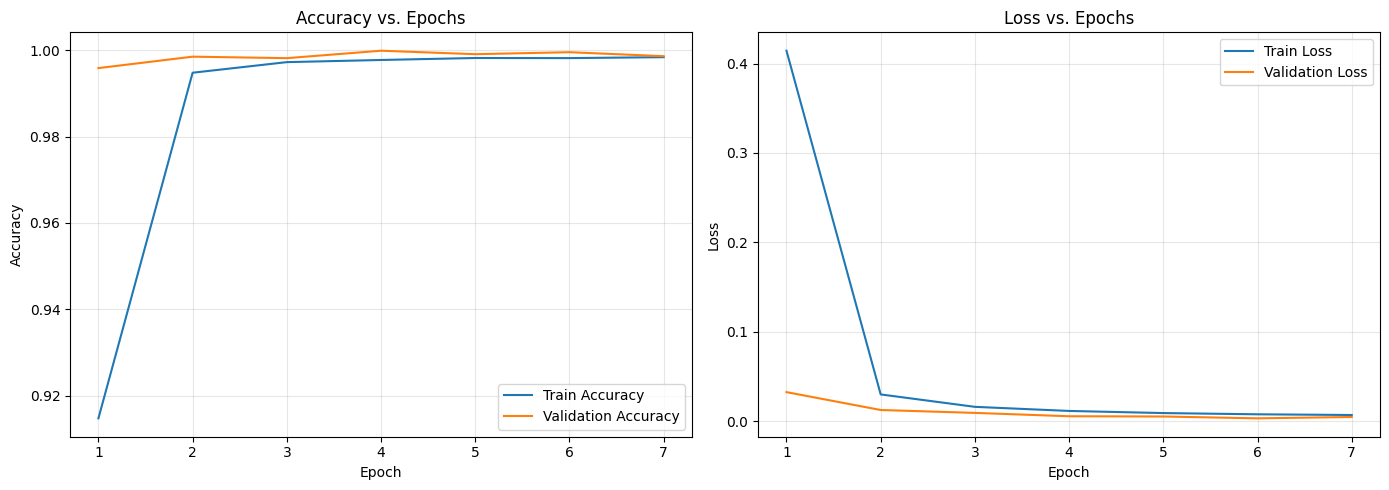

In [21]:
# --- Plot Learning Curves ---
df_hist = pd.read_csv(RESULTS / "TB_FT_training_history.csv")
epochs_range = range(1, len(df_hist) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, df_hist["train_acc"], label="Train Accuracy")
plt.plot(epochs_range, df_hist["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, df_hist["train_loss"], label="Train Loss")
plt.plot(epochs_range, df_hist["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig(RESULTS / "TB_FT_learning_curves.png", dpi=200)
plt.show()

In [22]:
# --- Evaluation on Test Sets ---
def evaluate_on_test_set(model, test_dir, class_to_idx, transform, device, save_tag):
    print(f"\nEvaluating on '{save_tag}' test set...")
    paths = list(test_dir.glob('*.jpg'))
    if not paths:
        print(f"No images found in {test_dir}. Skipping.")
        return

    true_labels, pred_labels = [], []
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    with torch.no_grad():
        for img_path in paths:
            label_char = img_path.name.split('_')[0].upper()
            if label_char not in class_to_idx:
                continue

            true_idx = class_to_idx[label_char]
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            logits = model(img_tensor)
            pred_idx = logits.argmax(1).item()

            true_labels.append(true_idx)
            pred_labels.append(pred_idx)

    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average="macro", zero_division=0)
    print(f"Results for '{save_tag}': Accuracy = {acc:.4f}, Macro F1-Score = {f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(NUM_CLASSES)))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})
    plt.title(f"Confusion Matrix - {save_tag} Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    cm_path = RESULTS / f"confusion_matrix_{save_tag}.png"
    plt.savefig(cm_path, dpi=200)
    plt.show()
    print(f"Saved confusion matrix to {cm_path}")


Evaluating on 'TB_FT_Kaggle' test set...
Results for 'TB_FT_Kaggle': Accuracy = 1.0000, Macro F1-Score = 1.0000


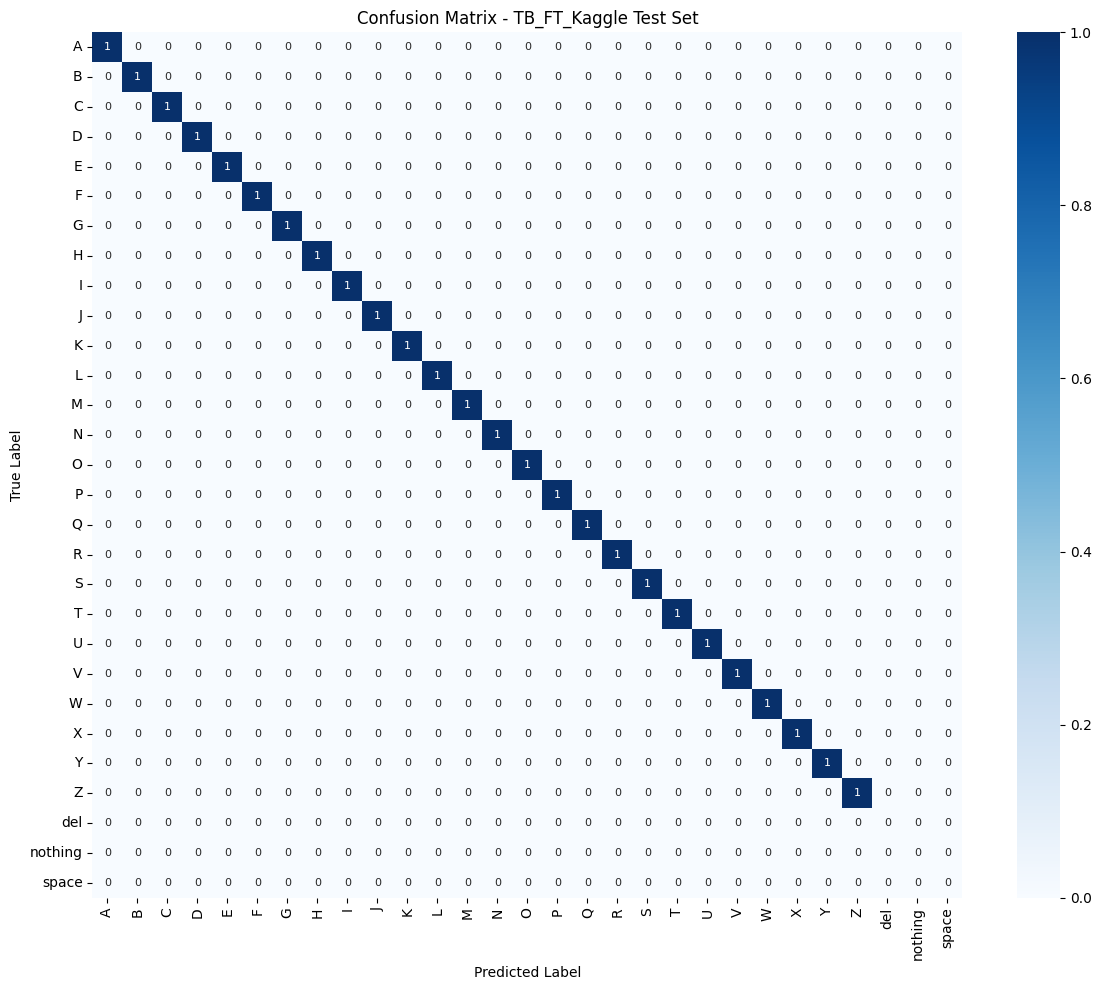

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_TB_FT_Kaggle.png

Evaluating on 'TB_FT_Custom' test set...
Results for 'TB_FT_Custom': Accuracy = 0.5238, Macro F1-Score = 0.3205


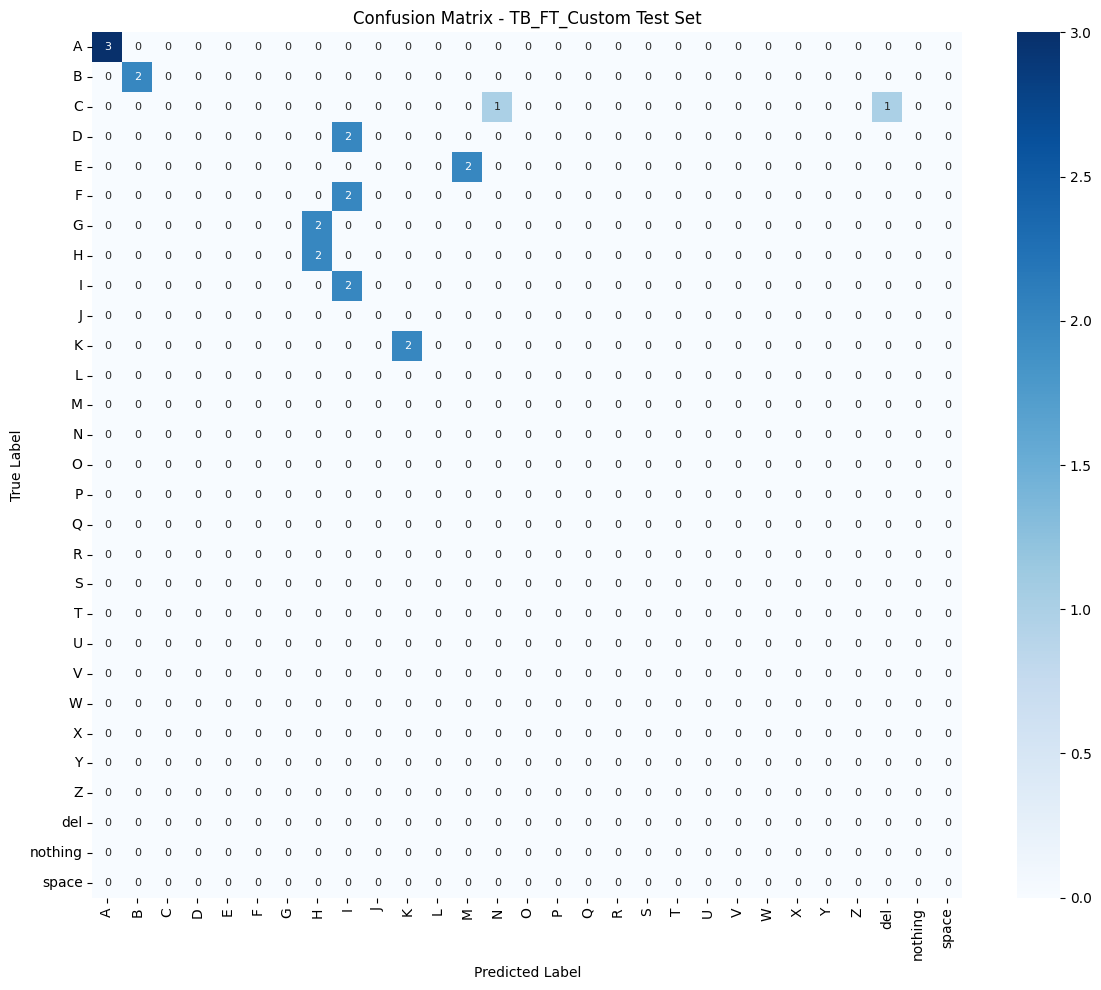

Saved confusion matrix to /content/drive/MyDrive/Bharde_429_Final/results/confusion_matrix_TB_FT_Custom.png


In [23]:
# Evaluate on Kaggle Test Set
KAGGLE_TEST_DIR = LOCAL_TEST
evaluate_on_test_set(model_for_eval, KAGGLE_TEST_DIR, class_to_idx, val_test_transform, DEVICE, "TB_FT_Kaggle")

# Evaluate on Custom Test Set
MY_TEST_DIR = PROJECT_ROOT / "Kayla_Custom_Test"
if MY_TEST_DIR.exists():
    evaluate_on_test_set(model_for_eval, MY_TEST_DIR, class_to_idx, val_test_transform, DEVICE, "TB_FT_Custom")
else:
    print(f"\nCustom test directory not found at {MY_TEST_DIR}. Skipping custom evaluation.")